In [1]:
import os
import datetime
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import glob
import scipy.io as sio

import netCDF4 as nc
from salishsea_tools import (viz_tools, tidetools, teos_tools)
from nowcast import (analyze, figures, research_ferries_test as rft)

%matplotlib inline

In [2]:
from importlib import reload

In [3]:
period = '1h'
grid = 'grid_T'
dmy = '14dec15'
date = datetime.datetime.strptime(dmy, "%d%b%y")
dayf = date - datetime.timedelta(days=1)
dmyf = dayf.strftime('%d%b%y').lower()
print(dmyf)

13dec15


Step 0: Load the datasets and files that are available in nowcast/make_plots. 
These will be used as inputs, not to be reloaded in the module

In [4]:
grid_T_hr = nc.Dataset(analyze.get_filenames(date, date, period, grid, '/results/SalishSea/nowcast/')[0])
coastline = sio.loadmat('/ocean/rich/more/mmapbase/bcgeo/PNW.mat')
grid_B = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
bathy, X, Y = tidetools.get_SS2_bathy_data()
ferry_data_path = '/ocean/jieliu/research/meopar/ONC_ferries/'

## A : Preparing ferry data
Step 1: Get ferry data

In [5]:
route_name='TWSB'
start_time = date.replace(hour=rft.route[route_name]['start']['hour'], minute=rft.route[route_name]['start']['minute'])
end_time = date.replace(hour=rft.route[route_name]['end']['hour'], minute=rft.route[route_name]['end']['minute'])
print(start_time, end_time)

2015-12-14 02:00:00 2015-12-14 04:00:00


In [6]:
obs = rft._get_sal_data(ferry_data_path, route_name, dmy)

Step 2: Slicing ferry data

In [7]:
obs_sal = rft.ferry_salinity(ferry_data_path, route_name, dmy, step=20)

## B: Preparing model data

In [8]:
sal_a, sal_b = rft._get_nemo_salinity('TWDP', grid_T_hr)

Testing plotting with NaN to jump over land

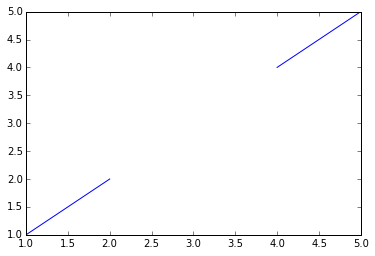

In [17]:
plt.plot([1, 2, 3, 4, 5],[1,2,np.NaN, 4, 5])

(48.75, 48.95)

/home/mdunn/anaconda3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


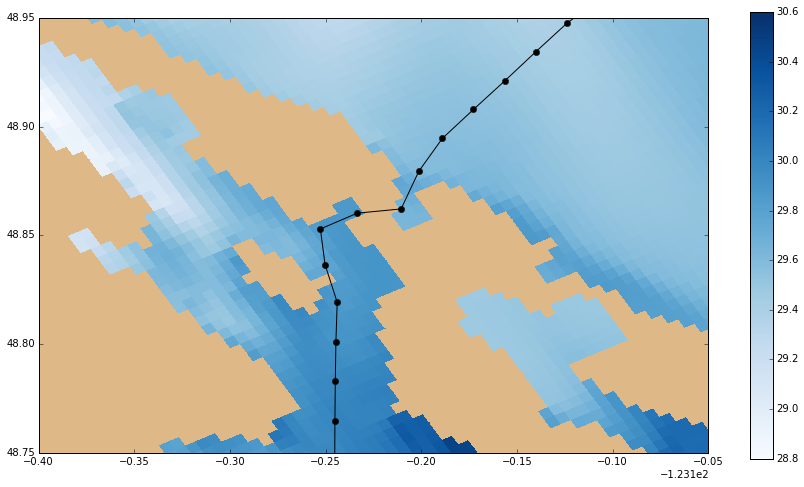

In [18]:
sal_ma = np.ma.masked_values(sal_a, 0)
fig, ax = plt.subplots(figsize=(15, 8))
cmap = plt.get_cmap('Blues')
cmap.set_bad('burlywood')
mesh = ax.pcolormesh(X, Y, sal_ma, cmap=cmap, vmin=28.8, vmax=30.6)
ax.plot(obs_sal[1], obs_sal[2], marker='o', color='black')
cbar = fig.colorbar(mesh)
viz_tools.set_aspect(ax)
ax.set_xlim(-123.5, -123.15)
ax.set_ylim(48.75, 48.95)
                

We must take into account that the model ferry route goes overland, we cannot interpolate over this area or have values for these datapoints

## C: Find corresponding model point to obs data
For each ferry route point we want to find the closest model point. From that model point we then find the 8 nearest points and compute and inverse distance interpolation.

In [11]:
rft._model_IDW(obs_sal[:,1], bathy, grid_T_hr, sal_a, sal_b)

(23.593798380670258, 21.48753547988365)

[ 18.35971403  21.58885842  27.98111499  28.1082286   29.18613976
  29.53480654  29.56283044  29.62662262  29.67319034  29.68751179
  29.71045059          nan          nan          nan  29.815768    28.5997901
  30.03304389  30.05834675  30.11095382  30.16161147  30.15652375
  30.14513827  27.89917296  28.19900894  24.33076791]


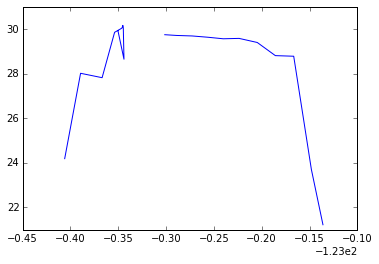

In [19]:
sal_val, sal_val_b = rft.nemo_sal_route(grid_T_hr, bathy, route_name, obs_sal)
print(sal_val_b)
plt.plot(obs_sal[1], sal_val)

In [13]:
val_a_sum = 0
val_b_sum = 0
weight_sum = 0
print(obs_sal.shape)
for k in np.arange(obs_sal.shape[1]):
    [x1, y1] = tidetools.find_closest_model_point(obs_sal[1,k],
                                                  obs_sal[2,k],
                                                  X,
                                                  Y,
                                                  bathy,
                                                  lat_tol=0.00210,
                                                  allow_land=True)

    interp_area = sal_a[x1-1:x1+2, y1-1:y1+2]
    if (interp_area.size - np.count_nonzero(interp_area)) >= 4:
        sal_a_idw = np.NaN
        sal_b_idw = np.NaN

    else:
        for i in np.arange(x1 - 1, x1 + 2):
            for j in np.arange(y1 - 1, y1 + 2):
                dist = tidetools.haversine(
                    obs_sal[1,k], obs_sal[2,k], X[i, j], Y[i, j])
                weight = 1.0 / dist
                weight_sum = weight_sum + weight
                if sal_a[i, j] == 0:
                    val_a_sum = val_a_sum
                    val_b_sum = val_b_sum
                else:
                    val_a = sal_a[i, j] * weight
                    val_b = sal_b[i, j] * weight
                    val_a_sum = val_a_sum + val_a
                    val_b_sum = val_b_sum + val_b

        sal_a_idw = val_a_sum / weight_sum
        sal_b_idw = val_b_sum / weight_sum

(4, 25)


In [14]:
reload(rft)

<module 'nowcast.research_ferries_test' from '/ocean/mdunn/MEOPAR/tools/SalishSeaNowcast/nowcast/research_ferries_test.py'>

/home/mdunn/anaconda3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


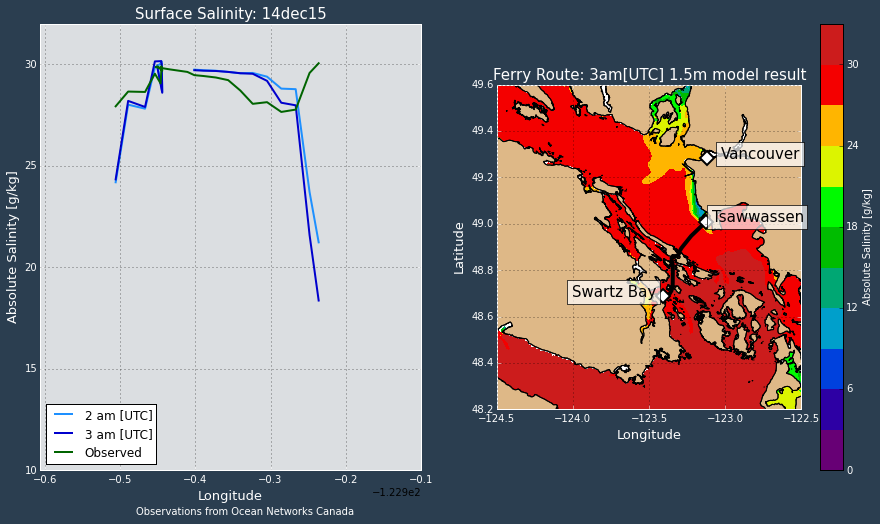

In [15]:
fig = rft.salinity_ferry_route(ferry_data_path, grid_T_hr, grid_B, bathy, coastline, 'TWSB', dmy)

/home/mdunn/anaconda3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


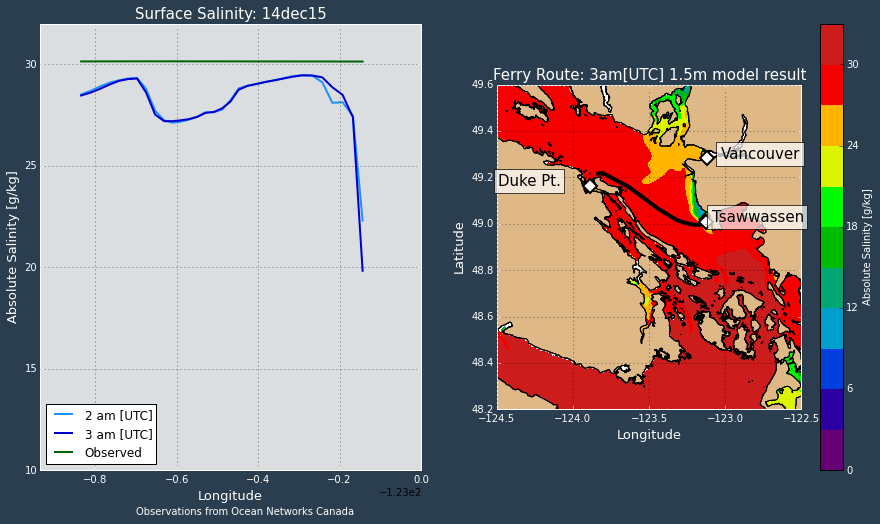

In [16]:
fig = rft.salinity_ferry_route(ferry_data_path, grid_T_hr, grid_B, bathy, coastline, 'TWDP', dmy)